In [4]:
import pandas as pd
import os
import torch
import json
import numpy as np

/home/lbcb02/anaconda3/envs/master_37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import seaborn as sns

In [6]:
%run ../Config.ipynb

In [7]:
config = Config()

#### Rmsd's 

In [12]:
file_name_rmsd = 'rmsd'
#file_name_rmsd = "rmsd_refined_set"

In [13]:
#path_4_comp = "/home/lbcb02/Workspace/BindRanker/BindRanker/Datahub/Backups/4complexes/Data"

In [14]:
rmsd = pd.read_csv(f"{config.data}/{file_name_rmsd}.csv").sort_values(['pdb','poserank','RMSD']).drop_duplicates(['pdb','poserank'], keep = 'first')

#rmsd = pd.read_csv(f"{path_4_comp}/{file_name_rmsd}.csv").sort_values(['pdb','poserank','RMSD']).drop_duplicates(['pdb','poserank'], keep = 'first')


sup = rmsd.groupby('pdb')[['poserank']].count().reset_index().rename(columns = {"poserank":"poserank_count"})
sup['unique_pdb_count'] = sup.groupby('poserank_count')['pdb'].transform('nunique')
sup.drop(columns = ['pdb']).drop_duplicates().sort_values('poserank_count')

,poserank_count,unique_pdb_count
32,1,2
134,2,3
4,3,5
253,4,1
42,5,4
...,...,...
40,95,4
36,96,8
43,97,9
49,98,17


In [15]:
rmsd['pdb'].nunique()

281

In [16]:
#rmsd[rmsd['pdb'] == "4kz6"]['poserank'].value_counts()

In [17]:
#rmsd[rmsd['pdb'] =='185l'].sort_values('poserank')

In [18]:
rmsd.head()

,pdb,poserank,RMSD
6904,1a30,1,4.38
6905,1a30,2,7.28
6906,1a30,3,5.40
6907,1a30,4,6.68
581,1a30,5,6.18


In [19]:
len(rmsd)

17871

<AxesSubplot:xlabel='poserank'>

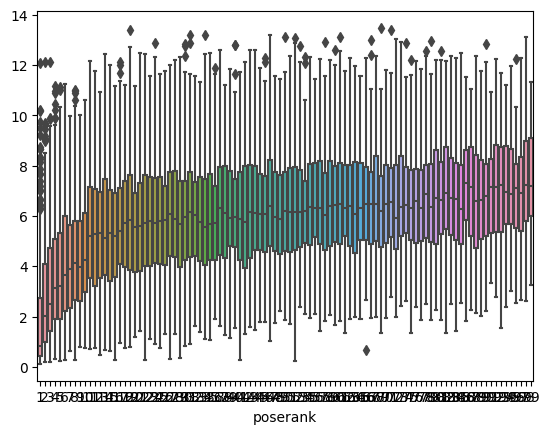

In [20]:
sns.boxplot(rmsd.pivot_table(index = 'pdb', columns = 'poserank', values = 'RMSD'))

#### Creating label 

In [21]:
label = rmsd.copy()

#### Score similarity 

In [24]:
score = pd.read_json(f"{config.data}/score.json").unstack().reset_index().rename(columns = {"level_0":"pdb", "level_1":"poserank", 0:'similarity'})

In [25]:
score.head()

,pdb,poserank,similarity
0,3oy8,1,8.641975
1,3oy8,2,4.938272
2,3oy8,3,7.407407
3,3oy8,4,3.703704
4,3oy8,5,6.172840


#### Merge

In [26]:
label = pd.merge(score, label, left_on= ['pdb','poserank'], right_on = ['pdb','poserank'], how = 'outer').drop_duplicates()

In [27]:
#label.sort_values('similarity', ascending = False).tail(30)

| score | rmsd |
|-------|------|
| rmsd < 2 | -10 |
| 2 < rmsd < 3 | -7 |
| rmsd > 3 | 0 |

| score | match |
|-------|-------|
| 79 | -10 |
| 70 | -7 |
| 66 | 0 |
| 42 | 0 |


#### Conditions

In [28]:
# Define the conditions and corresponding scores
conditions_rmsd = [ label['RMSD'] < 2
              ,(label['RMSD'] >= 2) & (label['RMSD'] < 3)
              , label['RMSD'] >= 3]

In [29]:
conditions_similarity = [ label['similarity'] >=80 
              ,(label['similarity'] >= 70) & (label['similarity'] < 80)
              #,(label['similarity'] >= 66) & (label['similarity'] < 70)
              , label['similarity'] < 70 ]

In [30]:
scores_rmsd       = [10, 7, 0]
scores_similarity = [10, 7, 0]

label['rmsd_weight'] = np.select(conditions_rmsd, scores_rmsd, default=np.nan)
label['similarity_weight'] = np.select(conditions_similarity, scores_similarity, default=np.nan)

#### Métrica 

$$
\frac{{\text{{score\_rmsd}} \times 0.5 + \text{{score\_match}} \times 0.5}}{{20}}
$$


In [37]:
label['weight'] = (label['rmsd_weight']*0.5 + label['similarity_weight']*0.5)/10
label['weight_similarity'] = (label['rmsd_weight']*0.3 + label['similarity_weight']*0.7)/10
label['weight_rmsd'] = (label['rmsd_weight']*0.7 + label['similarity_weight']*0.3)/10

In [38]:
label['weight'].value_counts()

0.00    312
0.35     16
0.50      9
0.85      2
Name: weight, dtype: int64

In [39]:
label["label"] = label["weight"].apply(lambda x: 1 if x > 0.5 else 0)

In [40]:
label.head()

,pdb,poserank,similarity,RMSD,rmsd_weight,similarity_weight,weight,weight_similarity,weight_rmsd,label
0,1a4k,1,44.705882,2.24,7.0,0.0,0.35,0.21,0.49,0
1,1a4k,2,55.294118,2.20,7.0,0.0,0.35,0.21,0.49,0
2,1a4k,3,60.000000,1.93,10.0,0.0,0.50,0.30,0.70,0
3,1a4k,4,67.058824,1.58,10.0,0.0,0.50,0.30,0.70,0
4,1a4k,5,9.411765,8.00,0.0,0.0,0.00,0.00,0.00,0


In [41]:
label[label['pdb'] == '1a4k'].head(50)

,pdb,poserank,similarity,RMSD,rmsd_weight,similarity_weight,weight,weight_similarity,weight_rmsd,label
0,1a4k,1,44.705882,2.24,7.0,0.0,0.35,0.21,0.49,0
1,1a4k,2,55.294118,2.20,7.0,0.0,0.35,0.21,0.49,0
2,1a4k,3,60.000000,1.93,10.0,0.0,0.50,0.30,0.70,0
3,1a4k,4,67.058824,1.58,10.0,0.0,0.50,0.30,0.70,0
4,1a4k,5,9.411765,8.00,0.0,0.0,0.00,0.00,0.00,0
5,1a4k,6,9.411765,7.68,0.0,0.0,0.00,0.00,0.00,0
6,1a4k,7,7.058824,10.24,0.0,0.0,0.00,0.00,0.00,0
7,1a4k,8,0.000000,9.06,0.0,0.0,0.00,0.00,0.00,0
8,1a4k,9,0.000000,9.09,0.0,0.0,0.00,0.00,0.00,0
9,1a4k,10,22.352941,10.18,0.0,0.0,0.00,0.00,0.00,0


In [34]:
label['label'].value_counts()

0    398
1      2
Name: label, dtype: int64

#### Stats

In [170]:
len(label['label'])

2840

In [171]:
label['pdb'].nunique()

284

In [172]:
label['label'].value_counts(1)

0    0.930986
1    0.069014
Name: label, dtype: float64

First the RMSD and the similarity metric is caulculated, 

| score | rmsd weight |
|-------|------|
| rmsd < 2 | 10 |
| 2 < rmsd < 3 | 7 |
| rmsd > 3 | 0 |

| score | match weight|
|-------|-------|
| > 80 | 10 |
| >= 70 | 7 |
| < 70 | 0| 


Then the score is thefined as 

$$
Score = \frac{{\text{{rmsd weight}} \times 0.3 + \text{{match weight}} \times 0.7}}{{20}}
$$

